In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import sys

%matplotlib inline
np.random.seed(777)

In [3]:
sys.path.append('./src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles

## Load KITTI GPS/IMU sequence

In [7]:
kitti_root_dir = '/home/swimming/Documents/Dev/Robotics/KITTI_Dataset'
kitti_date = '2011_09_26'
kitti_drive = '0027'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

Extract vehicle GPS trajectory, yaw angle, yaw rate, and forward velocity from KITTI OXTS senser packets.

These are treated as ground-truth trajectory in this experiment.

In [8]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

### Plot ground-truth GPS trajectory

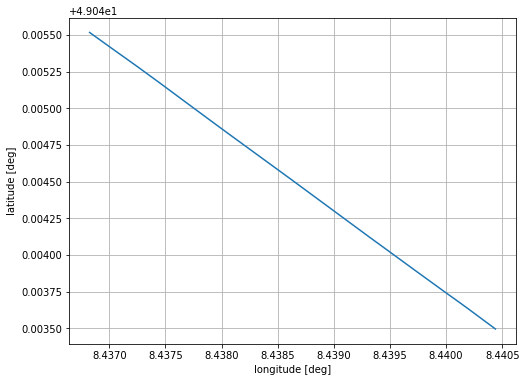

In [10]:
lons, lats, _ = gt_trajectory_lla

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(lons, lats)
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
ax.grid();

Transform GPS trajectory from [lon, lat, alt] to local [x, y, z] coord so that Kalman filter can handle it.

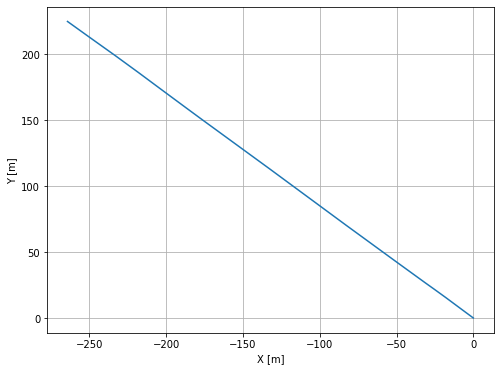

In [11]:
origin = gt_trajectory_lla[:, 0]  # set the initial position to the origin
gt_trajectory_xyz = lla_to_enu(gt_trajectory_lla, origin)

xs, ys, _ = gt_trajectory_xyz
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(xs, ys)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid();

Extract timestamps from KITTI data and convert them to seconds elapsed from the first one.

In [12]:
timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]

### Plot ground-truth yaw angles, yaw rates, and forward velocitis 

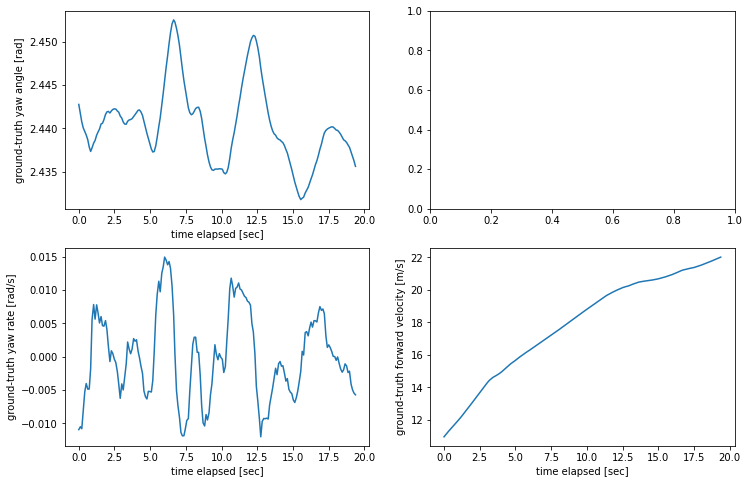

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(ts, gt_yaws)
ax[0, 0].set_xlabel('time elapsed [sec]')
ax[0, 0].set_ylabel('ground-truth yaw angle [rad]')

ax[1, 0].plot(ts, gt_yaw_rates)
ax[1, 0].set_xlabel('time elapsed [sec]')
ax[1, 0].set_ylabel('ground-truth yaw rate [rad/s]')

ax[1, 1].plot(ts, gt_forward_velocities)
ax[1, 1].set_xlabel('time elapsed [sec]')
ax[1, 1].set_ylabel('ground-truth forward velocity [m/s]');

## Add gaussian noise to KITTI GPU/IMU data

Add gaussian noise to the ground-truth GPS/IMU data.

Those are used as noisy observations given to Kalman filter later.

### Add noise to GPS data

In [14]:
N = len(ts)  # number of data point

In [15]:
xy_obs_noise_std = 5.0  # standard deviation of observation noise of x and y in meter

xy_obs_noise = np.random.normal(0.0, xy_obs_noise_std, (2, N))  # gen gaussian noise
obs_trajectory_xyz = gt_trajectory_xyz.copy()
obs_trajectory_xyz[:2, :] += xy_obs_noise  # add the noise to ground-truth positions

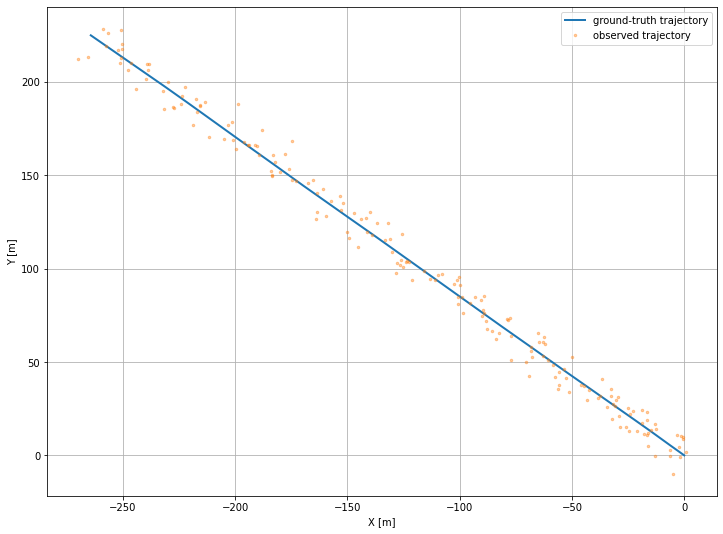

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=5, alpha=0.4, label='observed trajectory')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid();

### Add noise to yaw rates

In [17]:
yaw_rate_noise_std = 0.02 # standard deviation of yaw rate in rad/s

yaw_rate_noise = np.random.normal(0.0, yaw_rate_noise_std, (N,))  # gen gaussian noise
obs_yaw_rates = gt_yaw_rates.copy()
obs_yaw_rates += yaw_rate_noise  # add the noise to ground-truth positions

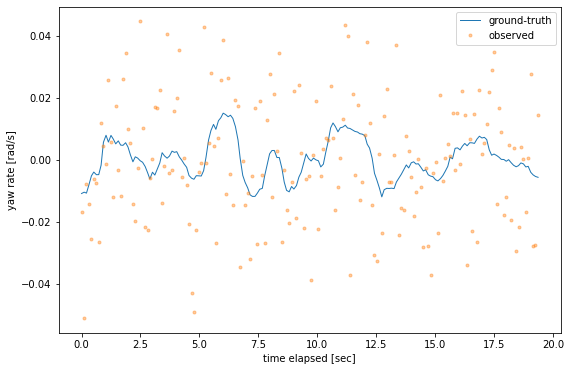

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_yaw_rates, lw=1, label='ground-truth')
ax.plot(ts, obs_yaw_rates, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw rate [rad/s]')
ax.legend();

### Add noise to forward velocities

In [19]:
forward_velocity_noise_std = 0.3 # standard deviation of forward velocity in m/s

forward_velocity_noise = np.random.normal(0.0, forward_velocity_noise_std, (N,))  # gen gaussian noise
obs_forward_velocities = gt_forward_velocities.copy()
obs_forward_velocities += forward_velocity_noise  # add the noise to ground-truth positions

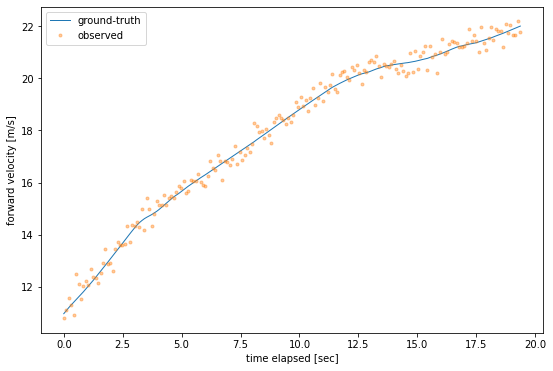

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_forward_velocities, lw=1, label='ground-truth')
ax.plot(ts, obs_forward_velocities, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('forward velocity [m/s]')
ax.legend();

## Apply Kalman filter!

Let's apply Kalman filter to the GPS/IMU sequence to estimate vehicle 2d pose [x, y, theta].

Be aware that the ground-truth data is used only for the evaluation. i.e., only noised GPS/IMU sequence is given to the filter.

### Prepare initial estimate and its error covariance

Suppose initial 2d position [x, y] estimation are initialized with the first GPS observation.

Since our vehicle has no sensor to measure yaw angle, yaw estimation is initialized randomly and its variance is initialized with some large value (e.g. pi).

In [21]:
# initial state x_0

initial_yaw_std = np.pi
initial_yaw = gt_yaws[0] + np.random.normal(0, initial_yaw_std)

x = np.array([
    obs_trajectory_xyz[0, 0],
    obs_trajectory_xyz[1, 0],
    initial_yaw
])

In [22]:
# covariance for initial state estimation error (Sigma_0)

P = np.array([
    [xy_obs_noise_std ** 2., 0., 0.],
    [0., xy_obs_noise_std ** 2., 0.],
    [0., 0., initial_yaw_std ** 2.]
])

### Prepare measuerment error covariance Q

In [23]:
Q = np.array([
    [xy_obs_noise_std ** 2., 0.],
    [0., xy_obs_noise_std ** 2.]
])

### Prepare state transition noise covariance R

In [24]:
R = np.array([
    [forward_velocity_noise_std ** 2., 0., 0.],
    [0., forward_velocity_noise_std ** 2., 0.],
    [0., 0., yaw_rate_noise_std ** 2.]
])

### Kalman filter main routine

In [25]:
# initialize Kalman filter
kf = EKF(x, P)

# array to store estimated 2d pose [x, y, theta]
mu_x = [x[0],]
mu_y = [x[1],]
mu_theta = [x[2],]

# array to store estimated error variance of 2d pose
var_x = [P[0, 0],]
var_y = [P[1, 1],]
var_theta = [P[2, 2],]

t_last = 0.
for t_idx in range(1, N):
    t = ts[t_idx]
    dt = t - t_last
    
    # get control input `u = [v, omega] + noise`
    u = np.array([
        obs_forward_velocities[t_idx],
        obs_yaw_rates[t_idx]
    ])
    
    # because velocity and yaw rate are multiplied with `dt` in state transition function,
    # its noise covariance must be multiplied with `dt**2.`
    R_ = R * (dt ** 2.)
    
    # propagate!
    kf.propagate(u, dt, R)
    
    # get measurement `z = [x, y] + noise`
    z = np.array([
        obs_trajectory_xyz[0, t_idx],
        obs_trajectory_xyz[1, t_idx]
    ])
    
    # update!
    kf.update(z, Q)
    
    # save estimated state to analyze later
    mu_x.append(kf.x[0])
    mu_y.append(kf.x[1])
    mu_theta.append(normalize_angles(kf.x[2]))
    
    # save estimated variance to analyze later
    var_x.append(kf.P[0, 0])
    var_y.append(kf.P[1, 1])
    var_theta.append(kf.P[2, 2])
    
    t_last = t
    

mu_x = np.array(mu_x)
mu_y = np.array(mu_y)
mu_theta = np.array(mu_theta)

var_x = np.array(var_x)
var_y = np.array(var_y)
var_theta = np.array(var_theta)

## Visualize estimated results

### trajectory

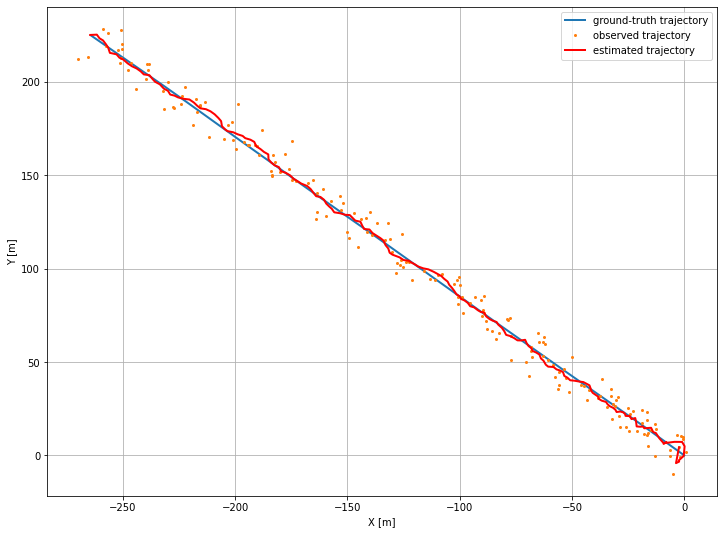

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory')

ax.plot(mu_x, mu_y, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

### Analyze estimation error of X

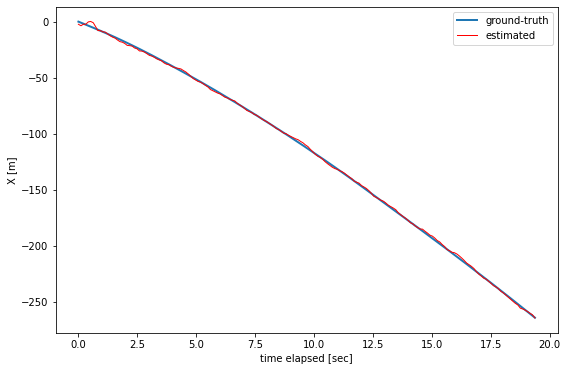

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[0], lw=2, label='ground-truth')
#ax.plot(ts, obs_trajectory_xyz[0], lw=0, marker='.', markersize=3, alpha=0.4, label='observed')
ax.plot(ts, mu_x, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('X [m]')
ax.legend();

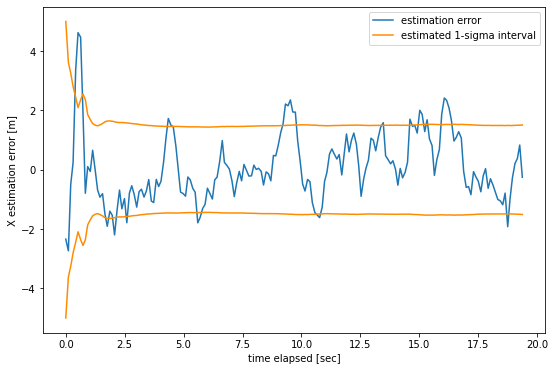

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, mu_x - gt_trajectory_xyz[0], lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_x), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_x), lw=1.5, label='', color='darkorange')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('X estimation error [m]')
ax.legend();

### Analyze estimation error of Y

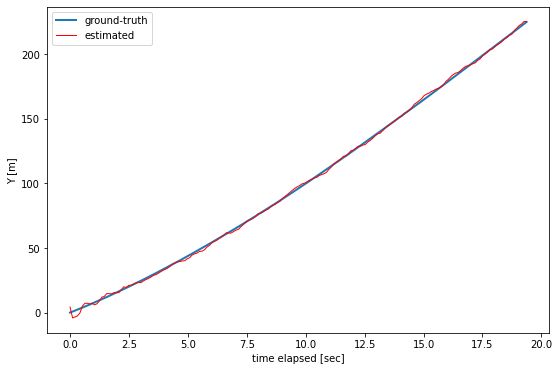

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[1], lw=2, label='ground-truth')
#ax.plot(ts, obs_trajectory_xyz[1], lw=0, marker='.', markersize=3, alpha=0.4, label='observed')
ax.plot(ts, mu_y, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('Y [m]')
ax.legend();

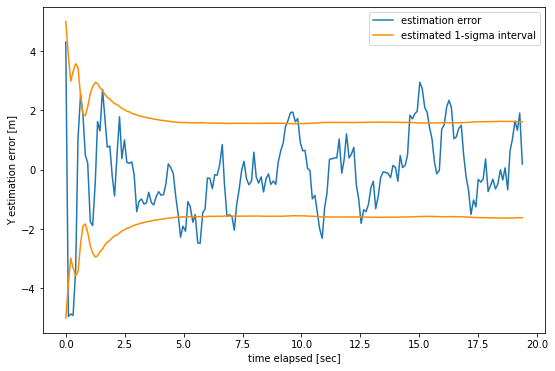

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, mu_y - gt_trajectory_xyz[1], lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_y), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_y), lw=1.5, label='', color='darkorange')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('Y estimation error [m]')
ax.legend();

### Analyze estimation error of Theta

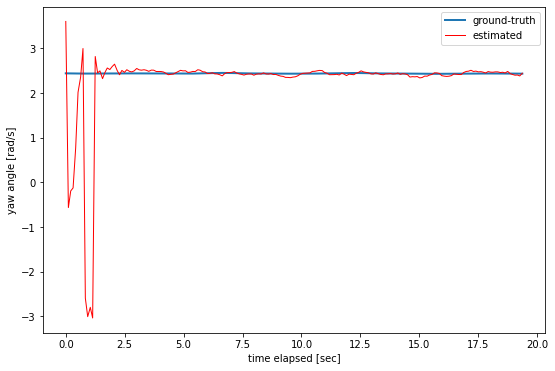

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_yaws, lw=2, label='ground-truth')
ax.plot(ts, mu_theta, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw angle [rad/s]')
ax.legend();

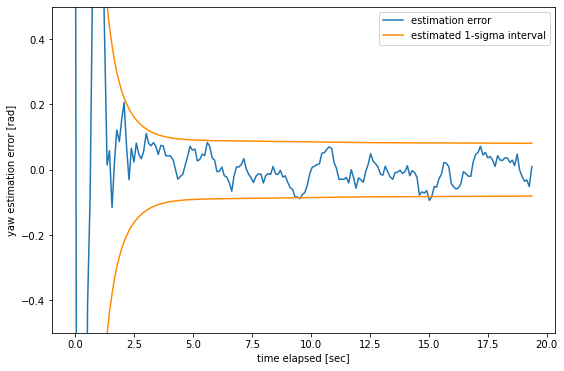

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, normalize_angles(mu_theta - gt_yaws), lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_theta), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_theta), lw=1.5, label='', color='darkorange')

ax.set_ylim(-0.5, 0.5)

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw estimation error [rad]')
ax.legend();

## Optional: generate shapefiles of vehicle trajectory

In [38]:
import geopandas as gpd
from shapely.geometry import LineString

from utils import enu_to_lla

In [39]:
def dump_to_shapefile(longitudes, latitudes, out_dir):
    geometry = []
    for i in range(1, len(longitudes)):
        lon, lat = longitudes[i], latitudes[i]
        lon_prev, lat_prev = longitudes[i - 1], latitudes[i - 1]
        geometry.append(
            LineString([
                (lon_prev, lat_prev),
                (lon, lat)
            ])
        )

    df = gpd.GeoDataFrame(geometry=geometry)
    df.to_file(
        driver='ESRI Shapefile',
        filename=out_dir
    )
    

# ground-truth
dump_to_shapefile(gt_trajectory_lla[0], gt_trajectory_lla[1], 'shapefiles/ground_truth')

# observed
obs_trajectory_lla = enu_to_lla(obs_trajectory_xyz, origin)
dump_to_shapefile(obs_trajectory_lla[0], obs_trajectory_lla[1], 'shapefiles/observed')

# estimated
est_trajectory_enu = np.stack([mu_x, mu_y, gt_trajectory_lla[2]])
est_trajectory_lla = enu_to_lla(est_trajectory_enu, origin)
dump_to_shapefile(est_trajectory_lla[0], est_trajectory_lla[1], 'shapefiles/estimated')